## A simple symmetric spring system

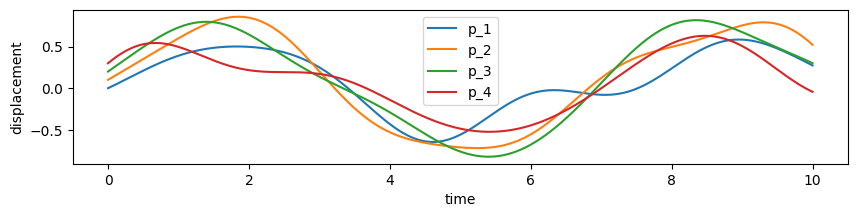

In [11]:
import numpy as np
import matplotlib.pyplot as plt

k = 2
m = 1

dt = 0.01
M = 1000

# full system dynamics
# after this code block, K is a 8 x 8 matrix modelling the flow of (p1,p2,p3,p4,dp1,dp2,dp3,dp4)
# with the above time discretization
K = 1/m * np.array([[-2*k, k, 0, 0], [k, -2*k, k, 0], [0, k, -2*k, k], [0, 0, k, -2*k]])
K = np.block([[np.zeros((4,4)), np.eye(4)], [K, np.zeros((4,4))]])

# initial state. y0[0,:] is (p1,p2,p3,p4); y0[1,:] is (dp1,dp2,dp3,dp4).
y0 = np.zeros((2,4)) 
y0[:,0] = [0,  0.4]
y0[:,1] = [0.1,0.5]
y0[:,2] = [0.2,0.6]
y0[:,3] = [0.3,0.7]
y0 = y0.flatten() # <- flattens

# simulate for M steps using the explicit Euler scheme
ys = np.empty((M,8))
ys[0,:] = y0
for k in range(ys.shape[0]-1): 
    ys[k+1] = ys[k] + dt * K @ ys[k]

# plots trajectory
fig, ax = plt.subplots(1,1,figsize=(10,2))
time = np.linspace(0,dt*M,M)
ax.plot(time, ys[:,0], label="p_1")
ax.plot(time, ys[:,1], label="p_2")
ax.plot(time, ys[:,2], label="p_3")
ax.plot(time, ys[:,3], label="p_4")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("displacement")
plt.show()

### The same mathematical computations, but using a group-convolutional approach:

convolution kernel:
A[e]: 
 [[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-4.  2.  0.  0.]
 [ 2. -4.  0.  0.]]

A[a]: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]

initial state:
y0[e] = [0.  0.1 0.4 0.5], y0[a] = [0.3 0.2 0.7 0.6]


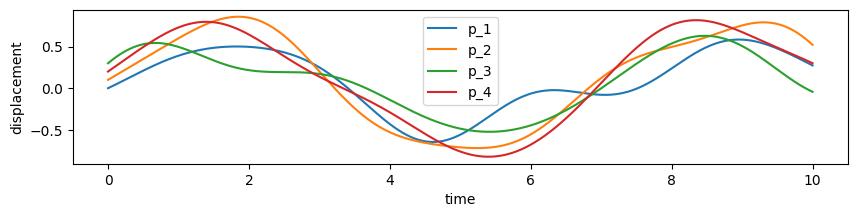

In [20]:
S = np.array([0,1,4,5])
G = [ "e", "a" ]

def op(g, h):
    # defines the operation of the reflection group
    if g!=h: return "a"
    if g==h: return "e"

def inverse(g):
    # inverse of a group element
    if g=="a": return "a"
    if g=="e": return "e"
    
def act(o, g):
    # the action of the group on an index o = 0,...,7 (we start counting with 0 instead of 1)
    if g == "a": 
        return  (o==0)*3 + (o==1)*2 + (o==2)*1 + (o==3)*0 + \
                (o==4)*7 + (o==5)*6 + (o==6)*5 + (o==7)*4
    if g == "e": return o

def group_convolve(A, z):
    # A : G -> C^{S x S}
    # z : G -> C^{S}
    # returns a dictionary : G -> C^S
    return { g: sum( A[h] @ z[ op(inverse(h), g) ] for h in G) for g in G }

# defines the convolution kernel
A = { g: K[:, act(S, inverse(g))][S,:] for g in G }
print("convolution kernel:")
print(f"A[e]: \n {A['e']}")
print()
print(f"A[a]: \n {A['a']}")
print()

# defines the initial state
y0_g = { g: y0[act(S, g)] for g in G }
print("initial state:")
print(f"y0[e] = {y0_g['e']}, y0[a] = {y0_g['a']}")

ys_conv = np.empty((M,8))
for k in range(M):
    # store current state
    ys_conv[k] = np.concatenate([y0_g[g] for g in G], axis=0)
    # computes group convolution
    conv = group_convolve(A, y0_g)
    # evolves the state forward in time using an explicit Euler scheme
    y0_g = { g: y0_g[g] + dt*conv[g] for g in G } 

# plots trajectory
fig, ax = plt.subplots(1,1,figsize=(10,2))
time = np.linspace(0,dt*M,M)
ax.plot(time, ys_conv[:,0], label="p_1")
ax.plot(time, ys_conv[:,1], label="p_2")
ax.plot(time, ys_conv[:,4], label="p_3")
ax.plot(time, ys_conv[:,5], label="p_4")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("displacement")
plt.show()